# Forest fire

This notebook presents an agent-based model that simulates a forest fire.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to work with a spatial grid and create animations, and perform a parameter sweep. 

In [1]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

## About the model

The model ist based on the [NetLogo FireSimple model](http://ccl.northwestern.edu/netlogo/models/FireSimple) by Uri Wilensky and William Rand, who describe it as follows:

> "This model simulates the spread of a fire through a forest. It shows that the fire's chance of reaching the right edge of the forest depends critically on the density of trees. This is an example of a common feature of complex systems, the presence of a non-linear threshold or critical parameter. [...] 
>
> The fire starts on the left edge of the forest, and spreads to neighboring trees. The fire spreads in four directions: north, east, south, and west.
>
>The model assumes there is no wind. So, the fire must have trees along its path in order to advance. That is, the fire cannot skip over an unwooded area (patch), so such a patch blocks the fire's motion in that direction."

## Model definition

In [2]:
class ForestModel(ap.Model):
    
    def setup(self):
        
        # Create agents (trees) 
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)
        
        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)      
        self.forest.add_agents(trees, random=True, empty=True)
        
        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Burned
        self.agents.condition = 0 
        
        # Start a fire from the left side of the grid
        unfortunate_trees = self.forest.agents[0:self.p.size, 0:2]
        unfortunate_trees.condition = 1 
        
    def step(self):
        
        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1)

        # Spread fire 
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree.condition = 2 # Tree burns out  
        
        # Stop simulation if no fire is left
        if len(burning_trees) == 0: 
            self.stop()
            
    def end(self):
        
        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees', 
                    burned_trees / len(self.agents))

## Single-run animation

In [3]:
# Define parameters

parameters = {
    'Tree density': 0.6, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 100,
}

In [4]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")

fig, ax = plt.subplots() 
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

## Parameter sweep

In [5]:
# Prepare parameter sample
parameters = {
    'Tree density': ap.Range(0.2, 0.6), 
    'size': 100
}
sample = ap.Sample(parameters, n=30)

In [6]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=40)
results = exp.run()

Scheduled runs: 1200
Completed: 1200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:03:09.242151


In [7]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_1
Loading from directory ap_output/ForestModel_1/
Loading parameters_constants.json - Successful
Loading parameters_sample.csv - Successful
Loading parameters_log.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful


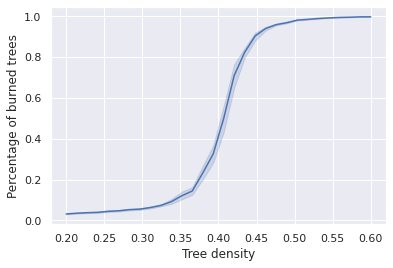

In [8]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Tree density', 
    y='Percentage of burned trees'
);